# Import libraries

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tqdm.notebook import tqdm
import warnings
import datetime
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
from mlxtend.plotting import plot_confusion_matrix
warnings.filterwarnings("ignore")
%matplotlib inline

# Data preprocessing

In [18]:
TRAIN_PATH = "/kaggle/input/intel-image-classification/seg_train/seg_train"
TEST_PATH = "/kaggle/input/intel-image-classification/seg_test/seg_test"
CLASS_NAMES = ["buldings", "forest", "glacier", "mountain", "sea", "street"]
IMG_SHAPE = (224,224)

In [19]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(TRAIN_PATH,
                                                                 batch_size=32,
                                                                 image_size=IMG_SHAPE,
                                                                 shuffle=True,
                                                                 label_mode="categorical",
                                                                 seed=42)
test_data = tf.keras.preprocessing.image_dataset_from_directory(TEST_PATH,
                                                                batch_size=32,
                                                                image_size=IMG_SHAPE,
                                                                shuffle=False,
                                                                label_mode="categorical",
                                                                seed=42)

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


In [20]:
samples = []
x = 0
for i in tqdm(train_data.unbatch()):
    if (x == 10):
        break
    samples.append([i[0], i[1]])
    x += 1

0it [00:00, ?it/s]

In [21]:
images = []
labels = []
for i in samples:
    images.append(i[0])
    labels.append(CLASS_NAMES[tf.argmax(i[1])])

In [22]:
len(images), len(labels)

(10, 10)

# Plot sample images

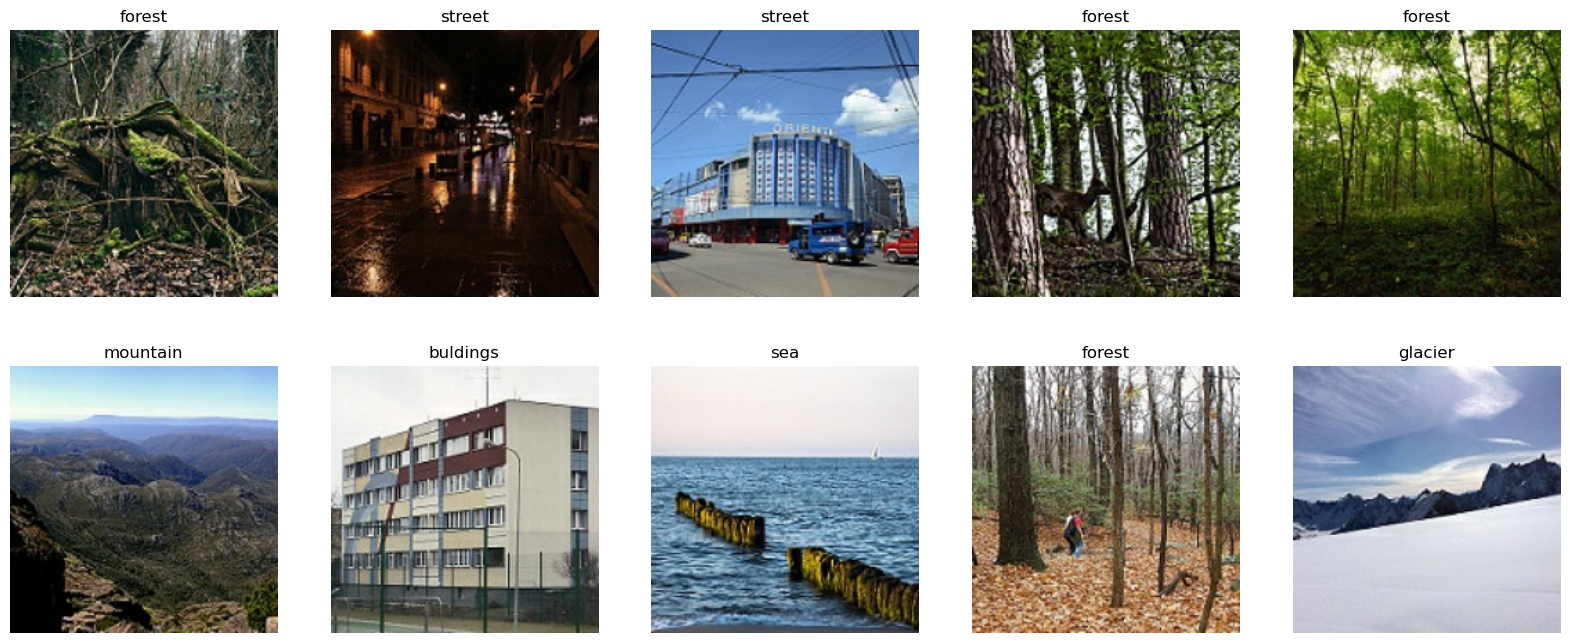

In [23]:
fig = plt.figure(figsize=(20, 8))
rows = 2
cols = 5
x = 1
for image, label in zip(images, labels):
    fig.add_subplot(rows, cols, x)
    plt.imshow(image/255.)
    plt.axis("off")
    plt.title(label)
    x += 1

# Model building phase

In [24]:
data_augmentation_block = tf.keras.models.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
], name="data_augmentation")

In [25]:
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [26]:
dir_name = "model_logs"
experiment_name = "EfficientNetB4 feature extraction"
tensorboarder = create_tensorboard_callback(dir_name, experiment_name)

Saving TensorBoard log files to: model_logs/EfficientNetB4 feature extraction/20230316-071209


In [27]:
checkpoint_path = "checkpoints/model.ckpt"
checkpointer = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                 monitor="val_accuracy",
                                                 save_best_only=False,
                                                 save_weights_only=True)

In [28]:
earlystopper = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                               patience=3,
                                               restore_best_weights=True)

# EfficientNetB4 feature extraction

In [29]:
base = tf.keras.applications.EfficientNetB4(include_top=False)
base.trainable = False

71686520/71686520 [==============================] - 0s 0us/step


In [30]:
inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")
x = data_augmentation_block(inputs)
x = base(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(len(CLASS_NAMES), activation="softmax", name="output_layer")(x)
model = tf.keras.models.Model(inputs, outputs)

model.compile(loss="categorical_crossentropy",
             optimizer="adam",
             metrics=["accuracy"])

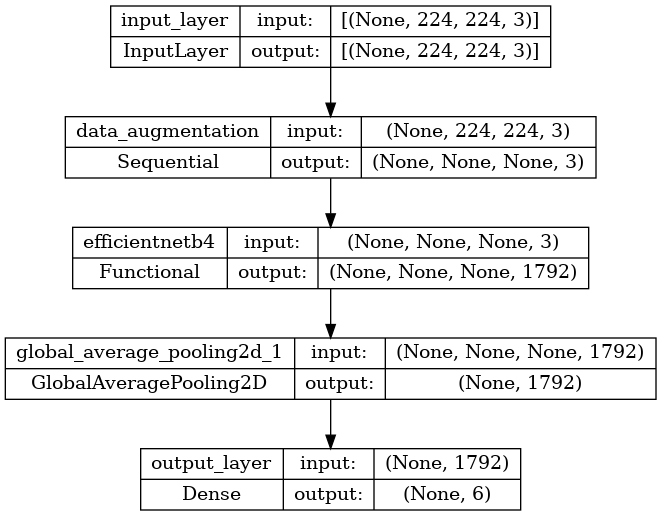

In [31]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [32]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb4 (Functional)  (None, None, None, 1792)  17673823 
                                                                 
 global_average_pooling2d_1   (None, 1792)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 output_layer (Dense)        (None, 6)                 10758     
                                                                 
Total params: 17,684,581
Trainable params: 10,758
Non-train

In [33]:
history = model.fit(train_data, 
                    epochs=50, 
                    batch_size=32, 
                    validation_data=(test_data), 
                    callbacks=[tensorboarder, checkpointer, earlystopper],
                    validation_steps=int(0.15*len(test_data)), 
                    use_multiprocessing=True)

Epoch 1/50
439/439 [==============================] - 173s 354ms/step - loss: 0.4451 - accuracy: 0.8467 - val_loss: 0.2627 - val_accuracy: 0.9062
Epoch 2/50
439/439 [==============================] - 135s 306ms/step - loss: 0.3106 - accuracy: 0.8881 - val_loss: 0.2315 - val_accuracy: 0.9241
Epoch 3/50
439/439 [==============================] - 131s 299ms/step - loss: 0.2870 - accuracy: 0.8965 - val_loss: 0.2809 - val_accuracy: 0.9085
Epoch 4/50
439/439 [==============================] - 126s 286ms/step - loss: 0.2758 - accuracy: 0.9004 - val_loss: 0.3037 - val_accuracy: 0.8951
Epoch 5/50
439/439 [==============================] - 124s 281ms/step - loss: 0.2696 - accuracy: 0.9007 - val_loss: 0.2414 - val_accuracy: 0.9219


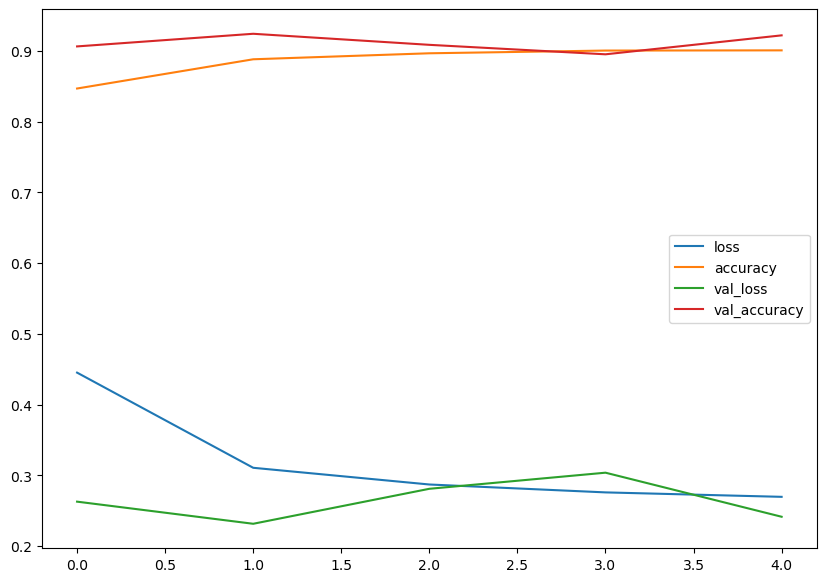

In [34]:
pd.DataFrame(history.history).plot(figsize=(10,7))
plt.show()

In [35]:
model.evaluate(test_data)

94/94 [==============================] - 10s 111ms/step - loss: 0.2440 - accuracy: 0.9183


[0.2440146505832672, 0.9183333516120911]

In [36]:
predictions = model.predict(test_data)

94/94 [==============================] - 12s 96ms/step


In [37]:
predictions.shape

(3000, 6)

In [38]:
predictions = tf.argmax(predictions, axis=1)

In [39]:
y_test = []
for _, label in tqdm(test_data.unbatch()):
    y_test.append(tf.argmax(label))

0it [00:00, ?it/s]

In [40]:
y_test = tf.Variable(y_test)

In [41]:
print(accuracy_score(y_test, predictions))

0.9183333333333333


In [42]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       437
           1       0.99      0.99      0.99       474
           2       0.84      0.88      0.86       553
           3       0.91      0.82      0.86       525
           4       0.93      0.98      0.96       510
           5       0.93      0.93      0.93       501

    accuracy                           0.92      3000
   macro avg       0.92      0.92      0.92      3000
weighted avg       0.92      0.92      0.92      3000



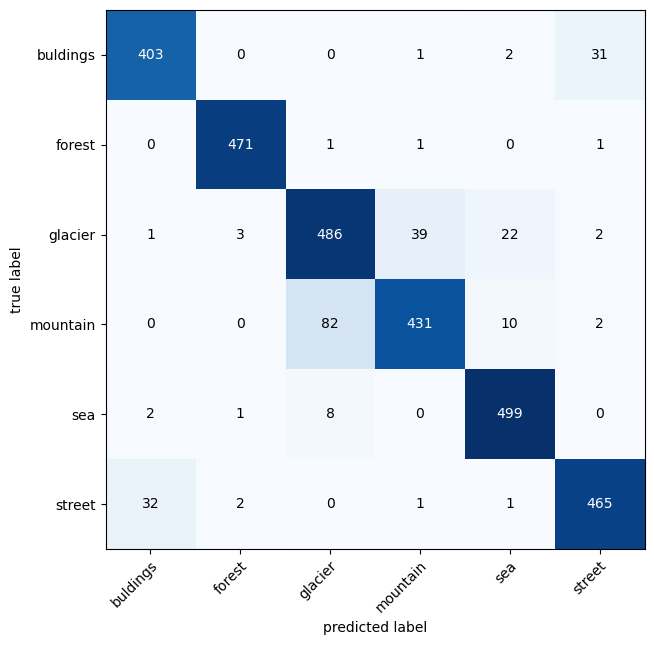

In [43]:
cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm, figsize=(10,7), class_names=CLASS_NAMES)
plt.show()

# EfficientNetB4 fine tuning

In [44]:
base.trainable = True
for layer in base.layers[:-10]:
    layer.trainable = False

In [45]:
model.compile(loss="categorical_crossentropy",
             optimizer=tf.keras.optimizers.Adam(learning_rate=0.00007),
             metrics=["accuracy"])

In [46]:
history_fine_tuning = model.fit(train_data, 
                                epochs=50, 
                                batch_size=32, 
                                validation_data=(test_data), 
                                callbacks=[tensorboarder, checkpointer, earlystopper],
                                validation_steps=int(0.15*len(test_data)), 
                                use_multiprocessing=True,
                                initial_epoch=history.epoch[-1])

Epoch 5/50
439/439 [==============================] - 145s 291ms/step - loss: 0.2763 - accuracy: 0.8989 - val_loss: 0.2000 - val_accuracy: 0.9263
Epoch 6/50
439/439 [==============================] - 120s 272ms/step - loss: 0.2489 - accuracy: 0.9091 - val_loss: 0.1788 - val_accuracy: 0.9420
Epoch 7/50
439/439 [==============================] - 119s 269ms/step - loss: 0.2298 - accuracy: 0.9161 - val_loss: 0.2328 - val_accuracy: 0.9174
Epoch 8/50
439/439 [==============================] - 117s 267ms/step - loss: 0.2144 - accuracy: 0.9213 - val_loss: 0.2570 - val_accuracy: 0.9196
Epoch 9/50
439/439 [==============================] - 119s 271ms/step - loss: 0.2049 - accuracy: 0.9239 - val_loss: 0.2101 - val_accuracy: 0.9286


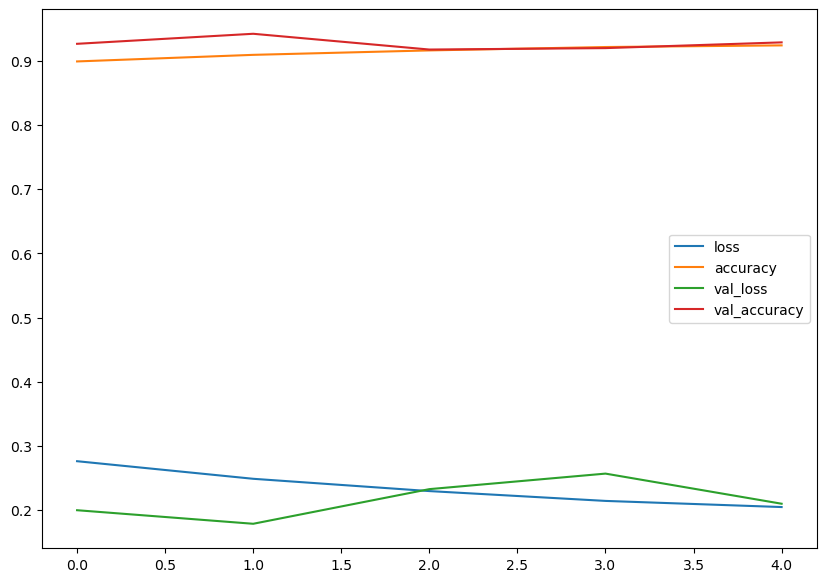

In [47]:
pd.DataFrame(history_fine_tuning.history).plot(figsize=(10,7))
plt.show()

In [48]:
model.evaluate(test_data)

94/94 [==============================] - 10s 101ms/step - loss: 0.2052 - accuracy: 0.9257


[0.20515696704387665, 0.9256666898727417]

In [49]:
predictions = model.predict(test_data)
predictions = tf.argmax(predictions, axis=1)
y_test = []
for _, label in tqdm(test_data.unbatch()):
    y_test.append(tf.argmax(label))
y_test = tf.Variable(y_test)

94/94 [==============================] - 12s 95ms/step


0it [00:00, ?it/s]

In [50]:
print(accuracy_score(y_test, predictions))

0.9256666666666666


In [51]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       437
           1       0.99      1.00      0.99       474
           2       0.87      0.87      0.87       553
           3       0.89      0.86      0.88       525
           4       0.95      0.98      0.96       510
           5       0.94      0.92      0.93       501

    accuracy                           0.93      3000
   macro avg       0.93      0.93      0.93      3000
weighted avg       0.93      0.93      0.93      3000



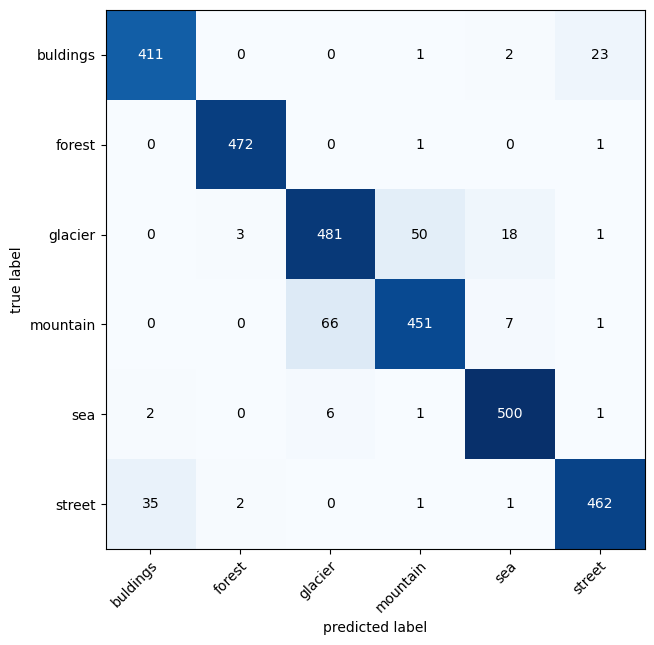

In [52]:
cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm, figsize=(10,7), class_names=CLASS_NAMES)
plt.show()

# Inference on shuffled test images

In [88]:
test_data_shuffled = tf.keras.preprocessing.image_dataset_from_directory(TEST_PATH,
                                                                        batch_size=32,
                                                                        image_size=IMG_SHAPE,
                                                                        shuffle=True,
                                                                        label_mode="categorical",
                                                                        seed=42)

Found 3000 files belonging to 6 classes.


1/1 [==============================] - 0s 67ms/step


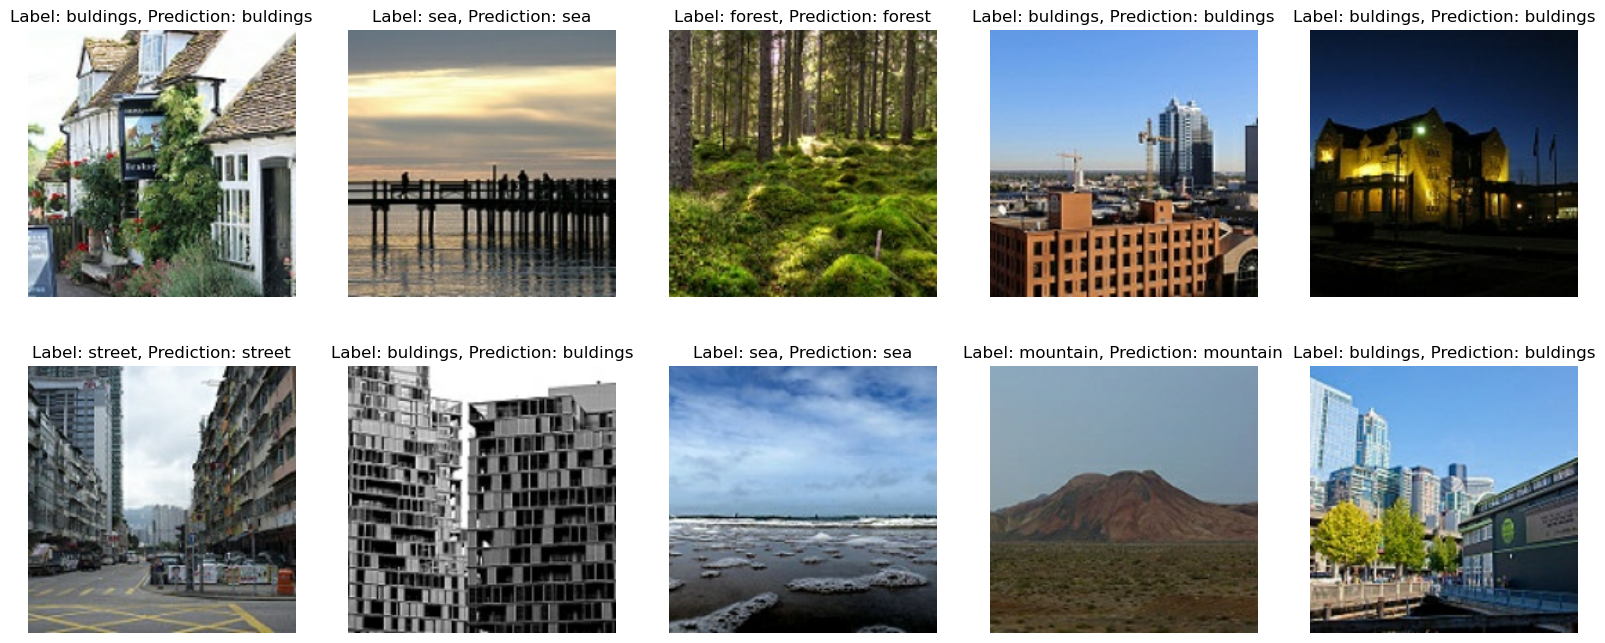

In [89]:
images = []
labels = []
x = 0
for i in test_data_shuffled.unbatch():
    if (x == 10):
        break
    images.append(i[0])
    labels.append(i[1])
    x += 1

fig = plt.figure(figsize=(20, 8))
rows = 2
cols = 5
x = 1
for image, label in zip(images, labels):
    fig.add_subplot(rows, cols, x)
    prediction = model.predict(tf.expand_dims(image, axis=0))
    prediction = CLASS_NAMES[tf.argmax(prediction.flatten())]
    label = CLASS_NAMES[tf.argmax(label)]
    plt.title(f"Label: {label}, Prediction: {prediction}")
    plt.imshow(image/255.)
    plt.axis("off")
    x += 1